# Load Packages

In [0]:
%%capture
!pip install "tensorflow>=2.0.0"
!pip install git+https://github.com/kmedian/keras-layernorm-rnn.git
!pip install lagmat

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from keras_layernorm_rnn import LayernormSimpleRNN
from lagmat import lagmat

import matplotlib.pyplot as plt
%matplotlib inline

# Generate Fake Dataset

In [0]:
n_obs = 2000    
delta = 0.05 
sigma = 0.5

t = np.arange(0, n_obs)
dat = np.cos(delta * t) + sigma * np.random.randn(n_obs)

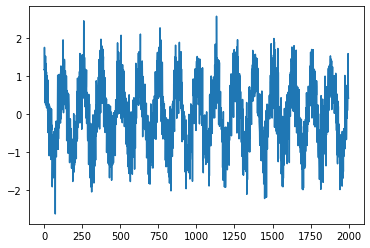

In [4]:
plt.plot(t, dat);

In [0]:
n_inp_steps = int(1. / delta)
n_out_steps = n_inp_steps // 2

mat = lagmat(dat, lags=range(n_inp_steps + n_out_steps))

In [6]:
print(mat[:6, :6])

[[1.1596281         nan        nan        nan        nan        nan]
 [1.15524555 1.1596281         nan        nan        nan        nan]
 [1.75009334 1.15524555 1.1596281         nan        nan        nan]
 [1.30836594 1.75009334 1.15524555 1.1596281         nan        nan]
 [0.92643114 1.30836594 1.75009334 1.15524555 1.1596281         nan]
 [0.95617406 0.92643114 1.30836594 1.75009334 1.15524555 1.1596281 ]]


In [0]:
# chop the nan away
idx_start = n_inp_steps + n_out_steps - 1
mat = mat[idx_start:, :]

In [0]:
# divide into y, X
X, y = mat[:, :n_inp_steps], mat[:, n_inp_steps:]

In [0]:
# data splitting
n_train = int(n_obs * 0.8)
X_train, X_valid = X[:n_train, :], X[n_train:, :]
Y_train, Y_valid = y[:n_train, :], y[n_train:, :]

In [0]:
# reshape input sequences for Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
# reshape output sequences for Keras
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
Y_valid = np.reshape(Y_valid, (Y_valid.shape[0], Y_valid.shape[1], 1))

In [11]:
X_valid.shape, Y_valid.shape

((371, 20, 1), (371, 10, 1))

# Modelling

# model1 - SimpleRNN

In [0]:
n_features = 1   # Input sequence is a simple univariate time series
n_targets = 1  # Output sequence is a simple univariate time series
n_rnn = 8
n_relu = 3

model1 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

opt_args = {
    'loss': 'mean_squared_error',
    'optimizer': tf.keras.optimizers.Adam(1e-4)
}

model1.compile(**opt_args)

## model2 - LayernormSimpleRNN

In [0]:
model2 = tf.keras.Sequential([
    LayernormSimpleRNN(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model2.compile(**opt_args)

## model 3 - LSTM

In [0]:
model3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model3.compile(**opt_args)

# Training

In [0]:
train_args = {
    'epochs': 100,
    'batch_size': 16, 
    'steps_per_epoch': n_train // 16,
    'validation_data': (X_valid, Y_valid),
    'verbose': 0
}

In [16]:
%%time
history1 = model1.fit(X_train, Y_train, **train_args)

CPU times: user 1min 2s, sys: 2.54 s, total: 1min 5s
Wall time: 46.8 s


In [17]:
%%time
history2 = model2.fit(X_train, Y_train, **train_args)

CPU times: user 1min 52s, sys: 3.83 s, total: 1min 56s
Wall time: 1min 13s


In [18]:
%%time
history3 = model3.fit(X_train, Y_train, **train_args)

CPU times: user 1min 55s, sys: 5.51 s, total: 2min
Wall time: 1min 12s


# Compare

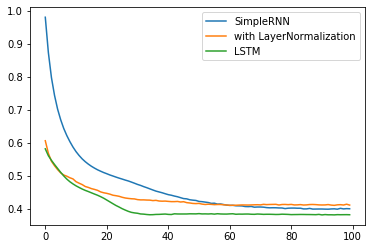

In [19]:
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.legend(["SimpleRNN", "with LayerNormalization", "LSTM"])
plt.show()